# DB backends experiments

## Description

Several experimetns on GO DB backends were performed in order to measure disk usage and operation times. 

## Util functions

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import re
import os

In [137]:
class Step:
    def __init__(self, name, du, records, duration):
        self.name = name
        self.du = du
        self.records = records
        self.duration = duration
        
    def __str__(self):
        return f"Step({self.name}, {self.du}, {self.records}, {self.duration})"
    
    def __repr__(self):
        return f"Step({self.name}, {self.du}, {self.records}, {self.duration})"
    
    def parse_from_tokens(tokens):
        if len(tokens) != 4:
            raise Exception("Incorrect line")
        name = tokens[0]
        du = int(tokens[1])
        records = int(tokens[2])
        duration = int(tokens[3].split('.')[0])
        return Step(name, du, records, duration)
        
    def parse_from_file(file_path):
        steps = []
        with open(file_path) as f:
            for ln in f.readlines():
                tokens = ln.strip().split()
                if len(tokens) == 0:
                    continue
                if tokens[0] in ['insert', 'delete']:
                    steps.append(Step.parse_from_tokens(tokens))
        return steps

In [122]:
def draw_experiment(experiment_name):
    measurementsDIR = "measurements"
    files = [f for f in os.listdir(measurementsDIR) if os.path.isfile(os.path.join(measurementsDIR, f))]
    files = list(filter(lambda f: f.startswith(experiment_name), files))
    n = len(files)
    
    fig, axs = plt.subplots(n, 3, figsize=(15, 4 * n))
    
    for i, file in enumerate(files):
        backend = re.split('_|\.', file)[1]
        steps = Step.parse_from_file(os.path.join(measurementsDIR, file))
        draw_steps(axs[i], steps, backend)
        
    plt.tight_layout()
    plt.show()
        

def draw_steps(ax, steps, backend):
    durations = [step.duration for step in steps]
    dus = [step.du for step in steps]
    records = [step.records for step in steps]
    x = [i for i in range(len(steps))]
    
    ax[0].text(-0.5, 0.5, backend, transform=ax[0].transAxes, va="center", fontsize=18)
    
    ax[0].plot(x, durations) 
    ax[0].set_xticks(x)
    ax[0].set_xlabel("Steps")
    ax[0].set_ylabel("Durations")
    
    ax[1].plot(x, dus) 
    ax[1].set_xticks(x)
    ax[1].set_xlabel("Steps")
    ax[1].set_ylabel("Disk usage MiB")
    
    ax[2].plot(x, records) 
    ax[2].set_xticks(x)
    ax[2].set_xlabel("Steps")
    ax[2].set_ylabel("Records")

## Experiments

Each experiment is run in steps. Each step either inserts or deletes a number of random key-value pairs.

### Small inserts
In this experiment we perform simple inserts to DB. 
 * Key size: 64B
 * Value size: 1MiB
 * Inserted volume per step: 1GiB
 * Total storage goal: 10GiB

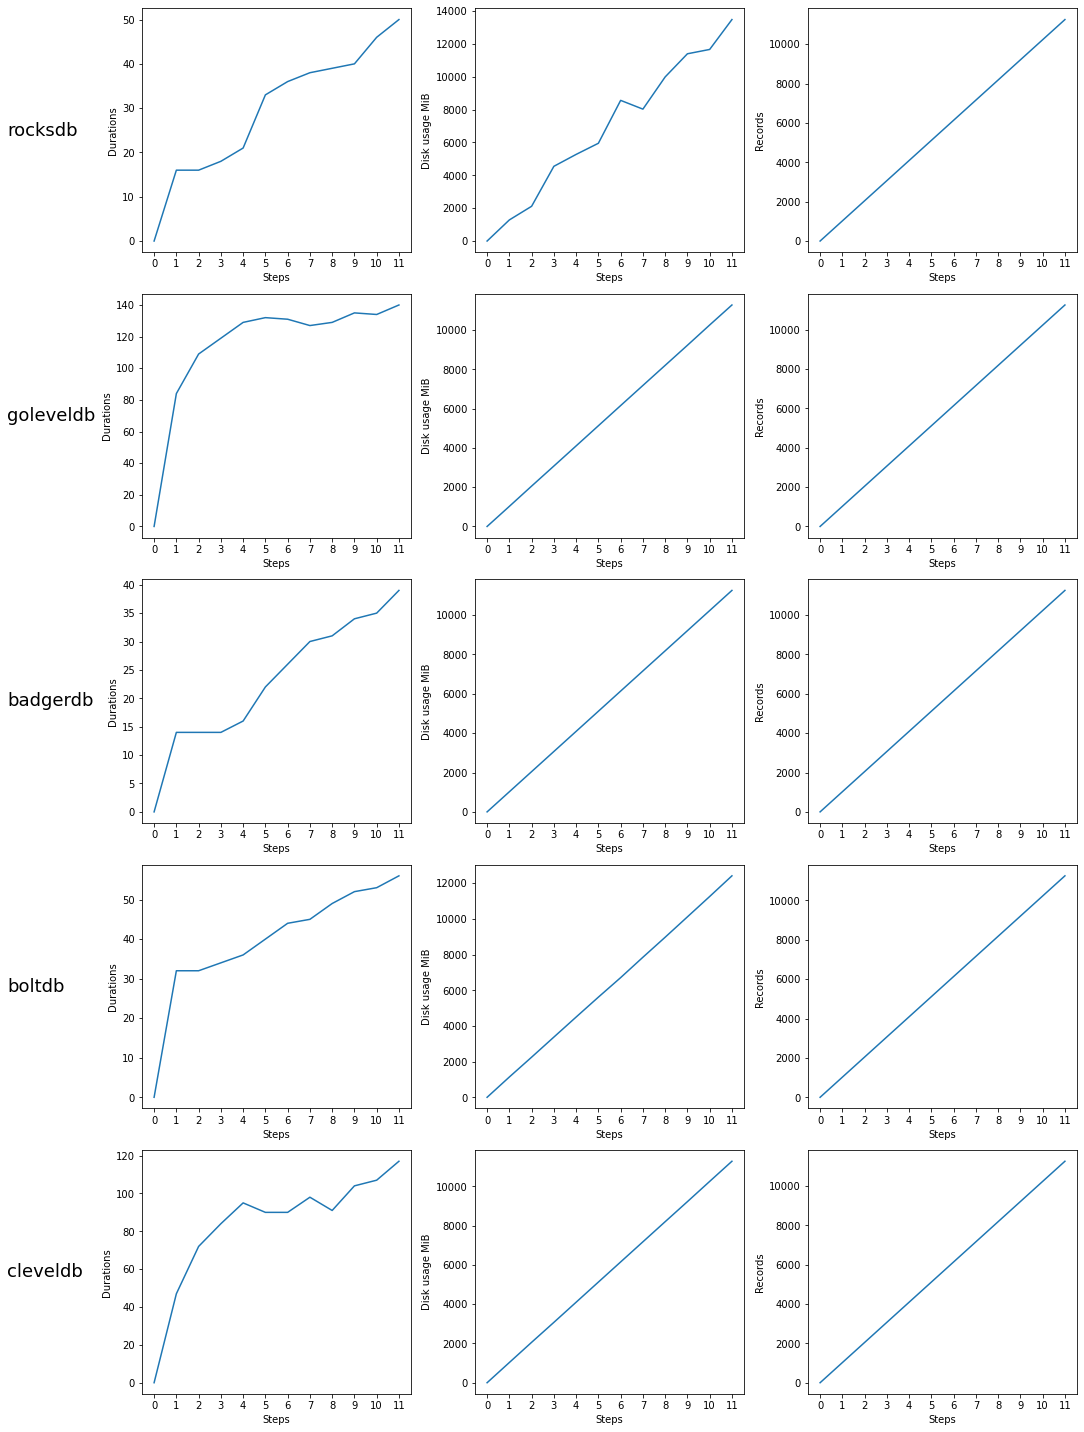

In [125]:
draw_experiment("BenchmarkSmallInserts")

#### Analysis
There are several points to note:
* For each backend the insertion time increases with a number of records present in the DB
* __cleveldb__ and __goleveldb__ are substantially slower
* __rocksdb__ disk usage does not 1 to 1 correspond to the actuall volume stored. Note that the result disk usage of __rocksdb__ is approximately 13GiB 

## Small deletions
In this experiment we perform simple deletions from DB after filling it to ~10GiB. 
 * Key size: 64B
 * Value size: 1MiB
 * Deleted volume per step: ~1GiB
 * Initial storage size: ~10GiB

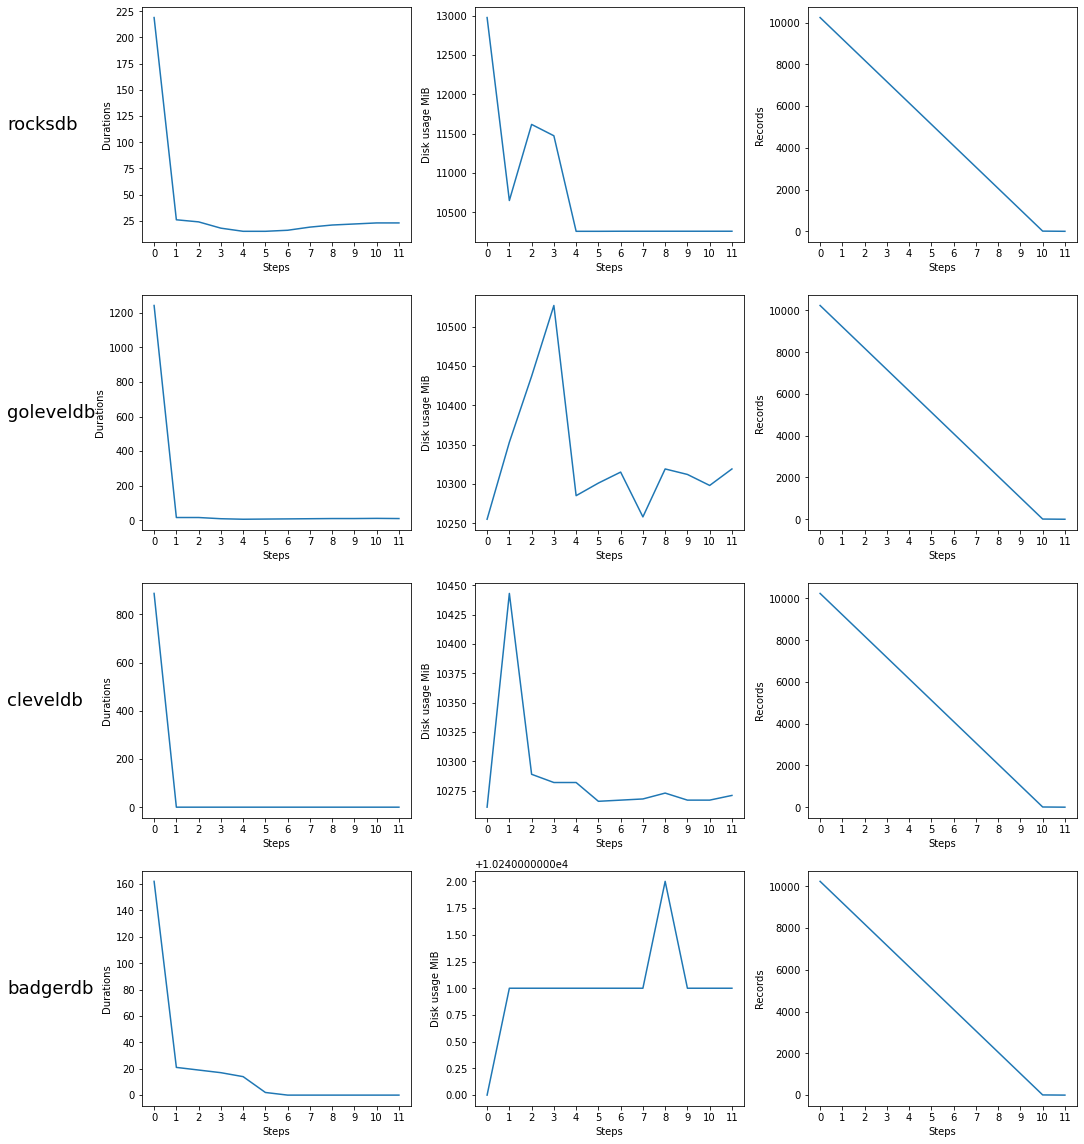

In [140]:
draw_experiment("BenchmarkSmallDeletions")

#### Analysis
* None of the backends perform real deletion from the disk
* Deletion time for __cleveldb__ and __goleveldb__ is neglectible, whereas for __rocksdb__ it is ~25sec/step and for __badgerdb__ it depends on the number of records present in the DB 
* Deleting can actually cause disk usage growth. The most noticable growth can be seen for __badgerdb__ (the storage volume is doubled)
* __boltb__ was not able to finish within an hour